# Aplicações do Modelo Clássico de Regressão Linear

In [1]:
# Importando bibliotecas
import pandas as pd
import seaborn as sn
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import statsmodels.formula.api as smf
import statsmodels.stats.diagnostic as dg
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
# Leitura e tratamento da base de dados
df = pd.read_stata('salario_stata11.dta')

# Convertendo tipos e visualizando dados
df = df.astype({
    'Sal':          'int8',
    'Exp':          'int8',
    'CursoCap':     'int8',
    'DummyMulher':  'int8',
    'Posgrad':      'int8'
})
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Sal          10 non-null     int8 
 1   Exp          10 non-null     int8 
 2   CursoCap     10 non-null     int8 
 3   DummyMulher  10 non-null     int8 
 4   Posgrad      10 non-null     int8 
dtypes: int8(5)
memory usage: 182.0 bytes


,Sal,Exp,CursoCap,DummyMulher,Posgrad
0,15,8,0,0,1
1,20,6,1,0,2
2,20,15,0,0,2
3,40,20,1,1,3
4,50,25,2,1,3
5,25,11,1,0,2
6,10,5,0,0,1
7,55,32,3,1,1
8,35,28,1,0,2
9,30,20,1,0,2


## Modelo de regressão

In [3]:
# Ajuste e Resultados do modelo de regressão
fit = smf.ols('Sal ~ Exp + CursoCap + DummyMulher + Posgrad', data=df).fit()
print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:                    Sal   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     374.9
Date:                Mon, 18 Nov 2024   Prob (F-statistic):           2.22e-06
Time:                        19:17:01   Log-Likelihood:                -12.146
No. Observations:                  10   AIC:                             34.29
Df Residuals:                       5   BIC:                             35.81
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.3996      1.282      4.211      

/home/herick/git/Aplicacoes-MCRL/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:418: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=10 observations were given.
  return hypotest_fun_in(*args, **kwds)


O R2 ajustado de 94,4% indica que as variáveis independentes tem têm um forte poder explicativo sobre a variável dependente.

Considerando o nível de significância de 5%, pode-se rejeitar a hipótese nula do teste t para todas as variáveis. A rejeição de Ho indica que todas são significativas na explicação da variável dependente.

## Teste de multicolinearidade

### Matriz de correlação

- 0 indica ausência de correlação linear entre as variáveis.
- 1 indica uma correlação perfeita.

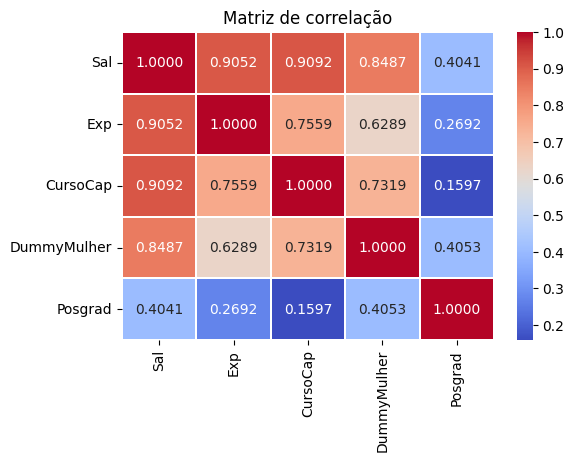

In [4]:
# Matriz de correlação
correlation = df.corr()

# plot da matriz de correlação
plt.figure(figsize=(6, 4))
plot = sn.heatmap(correlation, annot = True, fmt=".4f", linewidths=.1, cmap='coolwarm')
plt.title('Matriz de correlação')
plt.show()

### Análise dos Fatores de Inflação das Variâncias (VIF)

- VIF = 1 | Não correlacionados 
- 1 < VIF < 5 | Moderadamente correlacionados 
- VIF > 5 a 10 | Altamente correlacionados 

In [5]:
# Definindo o modelo para cálculo do VIF (Variance Inflation Factors)

# Ajustando a regressão para cálculo do VIF
y, X = dmatrices('Sal ~ Exp + CursoCap + DummyMulher + Posgrad', df, return_type='dataframe')

# Calculando VIF
vif = pd.DataFrame()
vif["Fator VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["Variável"] = X.columns
vif = vif[['Variável', 'Fator VIF']]

# Visualizar VIF Factors
vif.round(1)

,Variável,Fator VIF
0,Intercept,12.4
1,Exp,2.5
2,CursoCap,3.4
3,DummyMulher,2.7
4,Posgrad,1.3


## Teste de heterocedasticidade

Nível de significância de 5%

- Ho: o modelo é homocedástico
- H1: o modelo é heterocedástico

In [6]:
# Teste Breusch-Pagan (Teste de heterocedasticidade)

# Executar o Teste Breusch-Pagan
names = ['Lagrange multiplier statistic', 'p-value']
 
# Obter os resultados do teste
test_result = sms.het_breuschpagan(fit.resid, fit.model.exog)

result = pd.DataFrame(list(lzip(names, test_result[0:2])), columns=['Estatística', 'Valor'])
result = result.set_index('Estatística')
result.index.name = None
result

,Valor
Lagrange multiplier statistic,7.225701
p-value,0.124431


Considerando o nível de significância de 5%, não se rejeita Ho, portanto não há problema de heterocedasticidade no modelo estimado.

In [10]:
# Teste Breusch-Godfrey

#perform Breusch-Godfrey test
print('Sem defasagem:', dg.acorr_breusch_godfrey(fit))
print('Defasagem = 1:', dg.acorr_breusch_godfrey(fit, nlags=1))
print('Defasagem = 2:', dg.acorr_breusch_godfrey(fit, nlags=2))
print('Defasagem = 3:', dg.acorr_breusch_godfrey(fit, nlags=3))
print('Defasagem = 4:', dg.acorr_breusch_godfrey(fit, nlags=4))

Sem defasagem: (np.float64(7.116528712507057), np.float64(0.028488227242649555), 3.7020632440706067, 0.15483653604160544)
Defasagem = 1: (np.float64(2.2249545866258282), np.float64(0.13579665004180438), 1.1446644840420312, 0.3449335492914829)
Defasagem = 2: (np.float64(7.116528712507057), np.float64(0.028488227242649555), 3.7020632440706067, 0.15483653604160544)
Defasagem = 3: (np.float64(7.370252415759586), np.float64(0.06098763502216598), 1.8684308866569896, 0.36726254596915)
Defasagem = 4: (np.float64(8.482282172962549), np.float64(0.07542610473370938), 1.3972100119426962, 0.5548049237624096)


- Hipótese Nula (𝐻0): Os resíduos do modelo não possuem autocorrelação
- Hipótese Alternativa (H1): Os resíduos do modelo possuem autocorrelação


- chi2_stat: Estatística do teste Chi-quadrado.
- p_value: Valor-p do teste de Breusch-Godfrey.
- f_value: Estatística F para o teste.
- f_p_value: Valor-p da estatística F.